### Synteny and synteny hotspot code

The code in this notebook was written to create a synteny diagram of a given genomic region, particularly one with large repeats.  There is an option to add a "hotspot" track in the image corresponding to certain base pair patterns known to be associated with transposable elements.   

It operates mainly by using nucmer (from the MuMMer 3 or 4 software) to align a sequence with itself using the *maxmatch* option. This option will cause repeated genetic segments to be mutually aligned.  Then by deleting trivial "self alignments" we can see a visualization of how repeat regions feature in a given area of a genome. We annotate these diagrams with local genes of interest as well. 

This software is licensed under the Apache License, Version 2.0.  

Please cite "The Evolution of de novo Human-Specific MicroRNA Genes on Chromosome 21" by myself and coauthors, to appear in the *American Journal of Biological Anthropology* in 2022. 



In [230]:
import gffutils

"""
The following paths must be updated to local versions of these files. 
The file "hg38.db" is the output of the commented "db..." line below.
The gff3 file is any standard annotation of the human genome.
"""
filename="/home/hunter/Genome/Homo_sapiens.GRCh38.98.gff3"
database_filename = "/home/hunter/Documents/jupyter_nb/hg38.db"


"""
The command below builds a local database from the gff3 annotation file. 
It is time consuming to run, thus commented out.
"""
#db = gffutils.create_db(filename, dbfn=database_filename, force=True, keep_order=True, merge_strategy='merge', sort_attribute_values=True)

"""
Our work deals mostly with chromosome 21, but this can be changed.
"""
chromo=21

## see the documentation for gffutils
db = gffutils.FeatureDB(database_filename, keep_order=True)

#chr21fa="/home/hunter/Genome/hg38_chr21.fa"
chr21fa="/home/hunter/Genome/Fasta/human/chr21.fa"
#chr21fa="/home/hunter/Genome/human/masked_chr21_hg38.fa"

from Bio import SeqIO


ref_genome =  SeqIO.parse(chr21fa, "fasta")
chr21=next(ref_genome)

In [231]:
list(db.featuretypes())

['CDS',
 'C_gene_segment',
 'D_gene_segment',
 'J_gene_segment',
 'V_gene_segment',
 'biological_region',
 'chromosome',
 'exon',
 'five_prime_UTR',
 'gene',
 'lnc_RNA',
 'mRNA',
 'miRNA',
 'ncRNA',
 'ncRNA_gene',
 'pseudogene',
 'pseudogenic_transcript',
 'rRNA',
 'scRNA',
 'scaffold',
 'snRNA',
 'snoRNA',
 'tRNA',
 'three_prime_UTR',
 'unconfirmed_transcript',
 'vaultRNA_primary_transcript']

In [232]:

### Uncomment to save a copy of chr21

"""
ref_file = "/home/hunter/Genome/Homo_sapiens.GRCh38.dna.toplevel.fa"

ref_genome =  SeqIO.parse(ref_file, "fasta")


while True:
    rg=next(ref_genome)
    if rg.name=="21":
        break
fp=open(chr21fa,"w")
fp.write(rg.format("fasta"))
fp.close()"""

'\nref_file = "/home/hunter/Genome/Homo_sapiens.GRCh38.dna.toplevel.fa"\n\nref_genome =  SeqIO.parse(ref_file, "fasta")\n\n\nwhile True:\n    rg=next(ref_genome)\n    if rg.name=="21":\n        break\nfp=open(chr21fa,"w")\nfp.write(rg.format("fasta"))\nfp.close()'

In [233]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import os

def get_loc_features(chromo,start,end):
    """This returns a list of genomic features in a given chromosome, in a given range."""
    locFeatures = []
    print("{}:{}-{}".format(chromo,start,end))
    for e in db.region("{}:{}-{}".format(chromo,start,end)):
        if e.featuretype in ['miRNA','rRNA','snRNA','tRNA']:#['miRNA', 'rRNA','gene']:
            locFeatures.append([e.attributes["Name"][0],e.featuretype,chromo,e.start-start,e.end-start])
    return locFeatures


def write_region(contig,start,end,chromo):
    """This writes a specified part of a genome to a fasta file."""
    rg = chr21[start:end]
    loc="{}:{}-{}".format(chromo,start,end)

    ref_file = "/home/hunter/Genome/pnrma_{}.fa".format(loc)
    fp=open(ref_file,"w")
    fp.write(rg.format("fasta"))
    fp.close()
    return rg,loc,ref_file


def nuc_up(loc,ref_file,recompute=False):
    """
    This uses nucmer --maxmatch to align a given fasta file with itself.
    It uses the MuMMer 4 program "show-coords" to generate an uncompressed version of the
    alignment.  This output is then stored so as to be easily compatible with pandas. 
    """
    print("ref_file = {}".format(ref_file))
    if not os.path.exists("loc{}.delta".format(loc)) or recompute:
        !nucmer --maxmatch -p loc{loc} {ref_file} {ref_file}

    !show-coords -T -L 2000 loc{loc}.delta > pnrma_files/loc{loc}.coords

    numlines= !wc pnrma_files/loc{loc}.coords
    numlines = int(numlines[0].split()[0])

    !tail -{numlines-4} pnrma_files/loc{loc}.coords > rawdat
    !echo "[S1]\t[E1]\t[S2]\t[E2]\t[LEN 1]\t[LEN 2]\t[% IDY]\t[TAG1]\t[TAG2]" > header
    !cat header rawdat > pnrma_files/loc{loc}.coords
    print("nucup = pnrma_files/loc{}.coords".format(loc))


def big_intersection(s1,s2,e1,e2):
    """This code is to help identify parts of the alignment that are 'trivial'
       in the sense that nucmer has aligned some interval to itself so that they
       can be suppressed in the graphical output.
    """
    L = max([s1,s2])
    R = min([e1,e2])
    if (R-L)/(e1-s1)>0.99:
        return True
    return False

def get_intervals(loc,rg):
    """
    This takes the file produced by the `nuc_up` function and represents the alignment
    as pairs of intervals.  For every "top" interval there is a corresponding "bottom"
    interval which have been aligned by nucmer. The synteny is drawn by filling in 
    a rectangle whose top is the "top" interval and whose bottom is the "bottom"
    interval.
    """
    nuc_dat_file="pnrma_files/loc{}.coords".format(loc)
    columns=["s1","e1","s2","e2","len1","len2","pID","tag1","tag2"]
    df=pd.read_csv(nuc_dat_file,delimiter="\t",skiprows=1,header=None)
    df.columns=columns
    print("df shape = {}".format(df))
    print("df columns = {}".format(df.columns))
    s1,e1,s2,e2,len1,len2,pID,tag1,tag2 = df.columns
    top_intervals =[]
    bottom_intervals = []
    for i,r in df.iterrows():
        if not big_intersection(r[s1],r[s2],r[e1],r[e2]):  ### ignore self alignments
            s,e = int(r[s1]),int(r[e1])
            letters = str(rg.seq[s:e])
            percentN = (letters.count("N")/len(letters)) ### unknown areas trivially align and are ignored
            #rint(r[pID],type(r[pID]),r[pID]>85)
            if percentN > 0.99 or r[pID] < 90: ## ignore alignment if poor quality or unknown sequence
                continue
            top_intervals.append([r[s1],r[e1]])
            bottom_intervals.append([r[s2],r[e2]])
    return top_intervals,bottom_intervals




def drawpic(start,end,chrom,top_intervals,bottom_intervals,locFeatures):
    """
    Turns the intervals computed in get_intervals into rectangles using matplotlib polygons
    """
    width = end-start
    height = 1
    fig,ax = plt.subplots(figsize=(50,12))
    patches = []
    bottom_percent = 0
    top_percent = 0.5
    for t,b in zip(top_intervals,bottom_intervals):
        poly = [[t[0]/width,top_percent*height],[t[1]/width,top_percent*height],[b[1]/width,bottom_percent*height],[b[0]/width,bottom_percent*height]]
        polygon = Polygon(poly,True)
        patches.append(polygon)
    colors = np.random.rand(len(patches))
    p = PatchCollection(patches,alpha=0.5)
    p.set_array(np.array(colors))
    ax.add_collection(p)
    #fig.colorbar(p,ax=ax)
    baseheight = top_percent+0.025
    headlength = 0.01
    for f in locFeatures:
        rand_height_offset = np.random.random()*(1-top_percent)
        rho = rand_height_offset
        mp = (f[-2]+f[-1])/(2*width)
        ax.arrow(mp, baseheight+rho, 0,-(baseheight-top_percent+rho)+headlength, head_width=(f[-1]-f[-2])/width, head_length=headlength, fc='k', ec='k',alpha=0.2)
        ax.text(mp, baseheight+rho+0.01, f[0] , style='italic',
            bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})

    numticks = 20
    ticks = np.linspace(start,end,numticks,dtype=np.int32)
    for ti in ticks:
        ax.text((ti-start)/width,-0.1,str(ti),rotation=90)
    filename="panorama/{}_{}_{}.svg".format(chrom,start,end)
    plt.title("hg38 {}".format(loc))
    plt.axis('off')
    plt.savefig(filename, format="svg")
    plt.show()

    
    
def drawhotspot(start,end,chrom,top_intervals,bottom_intervals,locFeatures,H):
    """
    Much like `drawpic` but adds a "track" corresponding to n-mer hotspots
    """
    width = end-start
    height = 1
    fig,ax = plt.subplots(figsize=(50,14))
    #fig,ax = plt.subplots()
    
    patches = []
    bottom_percent = 0
    top_percent = 0.5
    for t,b in zip(top_intervals,bottom_intervals):
        poly = [[t[0]/width,top_percent*height],[t[1]/width,top_percent*height],[b[1]/width,bottom_percent*height],[b[0]/width,bottom_percent*height]]
        polygon = Polygon(poly,True)
        patches.append(polygon)
    colors = np.random.rand(len(patches))
    p = PatchCollection(patches,alpha=0.5)
    p.set_array(np.array(colors))
    ax.add_collection(p)
    #fig.colorbar(p,ax=ax)
    baseheight = top_percent+0.025
    headlength = 0.01
    for f in locFeatures:
        rand_height_offset = np.random.random()*(1-top_percent)
        rho = rand_height_offset
        mp = (f[-2]+f[-1])/(2*width)
        ax.arrow(mp, baseheight+rho-0.01, 0,-(baseheight-top_percent+rho)+headlength, head_width=(f[-1]-f[-2])/width, head_length=headlength, fc='k', ec='k',alpha=0.2)
        ax.text(mp, baseheight+rho, f[0] , style='italic',
            bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})

    numticks = 20
    ticks = np.linspace(start,end,numticks,dtype=np.int32)
        
    cszs = [(h[0])*20 for h in H]
    ccrds = [(h[1]-start)/width for h in H]
    chght = [1.1]*len(ccrds)
    ax.scatter(ccrds,chght,s=cszs,alpha=0.4)
        
    for ti in ticks:
        ax.text((ti-start)/width,-0.15,str(ti),rotation=90)
    filename="panorama/{}_{}_{}.svg".format(chrom,start,end)
    plt.title("hg38 {}".format(loc))
    #ax.axis('off')
    plt.savefig(filename, format="svg")
    plt.show()


In [234]:
### This makes the panorama -- commented out because I'm using this file to add hotspot features to a single image.
"""
base=0
incr=1000000
for i in range(15):
    start=base
    end=base+incr
    base += int(0.75*incr)



    locFeatures=get_loc_features(chromo,start,end)

    rg,loc,ref_file = write_region(chr21,start,end,chromo)



    nuc_up(loc,ref_file)    


    top_intervals,bottom_intervals = get_intervals(loc,rg)
    print("number of polygons: {}".format(len(top_intervals)))


    drawpic(start,end,chromo,top_intervals,bottom_intervals,locFeatures)"""

'\nbase=0\nincr=1000000\nfor i in range(15):\n    start=base\n    end=base+incr\n    base += int(0.75*incr)\n\n\n\n    locFeatures=get_loc_features(chromo,start,end)\n\n    rg,loc,ref_file = write_region(chr21,start,end,chromo)\n\n\n\n    nuc_up(loc,ref_file)    \n\n\n    top_intervals,bottom_intervals = get_intervals(loc,rg)\n    print("number of polygons: {}".format(len(top_intervals)))\n\n\n    drawpic(start,end,chromo,top_intervals,bottom_intervals,locFeatures)'

In [235]:
def newdrawpic(start,end,chrom,top_intervals,bottom_intervals,locFeatures,H=None):
    """slightly customized version of drawhotspot """
    width = end-start
    height = 1
    plt.rc('font', size=30) 

    fig,ax = plt.subplots(figsize=(50,20),facecolor='#FFFFFF')
    patches = []
    bottom_percent = 0
    top_percent = 0.5
    for t,b in zip(top_intervals,bottom_intervals):
        poly = [[t[0]/width,top_percent*height],[t[1]/width,top_percent*height],[b[1]/width,bottom_percent*height],[b[0]/width,bottom_percent*height]]
        polygon = Polygon(poly,True)
        patches.append(polygon)
    colors = np.random.rand(len(patches))
    p = PatchCollection(patches,alpha=0.5)
    p.set_array(np.array(colors))
    ax.add_collection(p)
    #fig.colorbar(p,ax=ax)
    baseheight = top_percent+0.025
    headlength = 0.01
    heightoffsets=np.linspace(0,1-top_percent,len(locFeatures))
    np.random.shuffle(heightoffsets)
    for i,f in enumerate(locFeatures):
        rand_height_offset = heightoffsets[i]
        rho = rand_height_offset
        mp = (f[-2]+f[-1])/(2*width)
        ax.arrow(mp, baseheight+rho, 0,-(baseheight-top_percent+rho)+headlength, head_width=(f[-1]-f[-2])/width, head_length=headlength, fc='k', ec='k',alpha=0.2)
        ax.text(mp, baseheight+rho+0.01, f[0] , style='italic',
            bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1},fontsize=40)

    if H:    
        cszs = [(h[0])*20 for h in H]
        ccrds = [(h[1]-start)/width for h in H]
        chght = [1.1]*len(ccrds)
        ax.scatter(ccrds,chght,s=cszs,alpha=0.4)
    
    
    numticks = 20
    inc=0.25*1000000
    ticks = np.arange(start,end,inc,dtype=np.int32)
    for ti in ticks:
        ax.text((ti-start)/width,-0.1,"{:.2f} Mb".format(ti/1000000),fontsize=35)
    nonce=np.random.randint(500)
    filename="panorama/{}_{}_{}nonce{}.svg".format(chrom,start,end,nonce)
    plt.title("hg38 {}".format(loc))
    plt.axis('off')
    plt.savefig(filename, format="svg")
    plt.show()


In [239]:
"""
The interval of the chromosome to be drawn
"""

start,end = 8100000,9100000

 
    
#start,end = 8000000,9000000  ### remove reduction of locFeatures coords below!


### This miRNA was unannotated in the gff and had to be manually added
mir10396Astart, mir10396Aend = 8987617-8000000, 8987665-8000000

mir10396Bstart, mir10396Bend = 8433222-8000000, 8436875-8000000


"""
Genomic Locations for MIR10396A Gene
Latest Assembly

chr21:8,987,617-8,987,665



Genomic Locations for MIR10396B Gene
Latest Assembly

chr21:8,433,222-8,436,875

"""
#RNA45SN
locFeatures=get_loc_features(chromo,start,end)
locFeatures=[['MIR6724-1', 'miRNA', 21, 205315, 205406],
 ['MIR3648-1', 'miRNA', 21, 208473, 208652],
 #['RNA5-8SN2', 'rRNA', 21, 212572, 212724],
 ['MIR6724-2', 'miRNA', 21, 249505, 249596],
 ['MIR6724-3', 'miRNA', 21, 388362, 388453],
 #['RNA5-8SN3', 'rRNA', 21, 395607, 395759],
 ['MIR6724-4', 'miRNA', 21, 432530, 432621],
 ['MIR10396b', 'miRNA',21,mir10396Bstart,mir10396Bend],
 #['RNA5-8SN1', 'rRNA', 21, 439823, 439975],
 ['RNA45SN1','rRNA',21,433222,446572],
 ['RNA45SN2','rRNA',21,205988,219302],
 ['RNA45SN3','rRNA',21,250197,402343],
 ['MIR3648-2', 'miRNA', 21, 986999, 987178],
 ['MIR10396a', 'miRNA',21,mir10396Astart,mir10396Aend]]

locFeatures
#RNA45SN1

21:8100000-9100000


[['MIR6724-1', 'miRNA', 21, 205315, 205406],
 ['MIR3648-1', 'miRNA', 21, 208473, 208652],
 ['MIR6724-2', 'miRNA', 21, 249505, 249596],
 ['MIR6724-3', 'miRNA', 21, 388362, 388453],
 ['MIR6724-4', 'miRNA', 21, 432530, 432621],
 ['MIR10396b', 'miRNA', 21, 433222, 436875],
 ['RNA45SN1', 'rRNA', 21, 433222, 446572],
 ['RNA45SN2', 'rRNA', 21, 205988, 219302],
 ['RNA45SN3', 'rRNA', 21, 250197, 402343],
 ['MIR3648-2', 'miRNA', 21, 986999, 987178],
 ['MIR10396a', 'miRNA', 21, 987617, 987665]]

In [238]:
for LF in locFeatures:
    LF[-1] -= (start-8000000)
    LF[-2] -= (start-8000000)
   


"""
Genomic Locations for RNA45SN1 Gene
Latest Assembly
chr21:8,433,222-8,446,572

Genomic Locations for RNA45SN2 Gene
Latest Assembly
chr21:8,205,988-8,219,302

Genomic Locations for RNA45SN3 Gene
Latest Assembly
chr21:8,250,197-8,402,343
"""
locFeatures

[['MIR6724-1', 'miRNA', 21, 5315, 5406],
 ['MIR3648-1', 'miRNA', 21, 8473, 8652],
 ['MIR6724-2', 'miRNA', 21, 49505, 49596],
 ['MIR6724-3', 'miRNA', 21, 188362, 188453],
 ['MIR6724-4', 'miRNA', 21, 232530, 232621],
 ['MIR10396b', 'miRNA', 21, 233222, 236875],
 ['RNA45SN1', 'rRNA', 21, 233222, 246572],
 ['RNA45SN2', 'rRNA', 21, 5988, 19302],
 ['RNA45SN3', 'rRNA', 21, 50197, 202343],
 ['MIR3648-2', 'miRNA', 21, 786999, 787178],
 ['MIR10396a', 'miRNA', 21, 787617, 787665]]

loc=21:8100000-9100000
ref_file = /home/hunter/Genome/pnrma_21:8100000-9100000.fa
nucup = pnrma_files/loc21:8100000-9100000.coords
df shape =          s1       e1      s2       e2     len1     len2     pID   tag1   tag2
0         1  1000000       1  1000000  1000000  1000000  100.00  chr21  chr21
1      5200    25218    5200    25218    20019    20019   99.99  chr21  chr21
2     34027   160971   34027   160971   126945   126945   99.70  chr21  chr21
3    217072   372360  217072   372360   155289   155289   99.61  chr21  chr21
4    422361   470217  422361   470217    47857    47857   99.94  chr21  chr21
..      ...      ...     ...      ...      ...      ...     ...    ...    ...
130  996391   998702  997674   999993     2312     2320   80.38  chr21  chr21
131  996391   999795  697593   694135     3405     3459   81.39  chr21  chr21
132  988925   999904  988925  1000000    10980    11076   97.89  chr21  chr21
133  996541  1000000  996397   999904     3460     3508   80.89  chr21  chr21


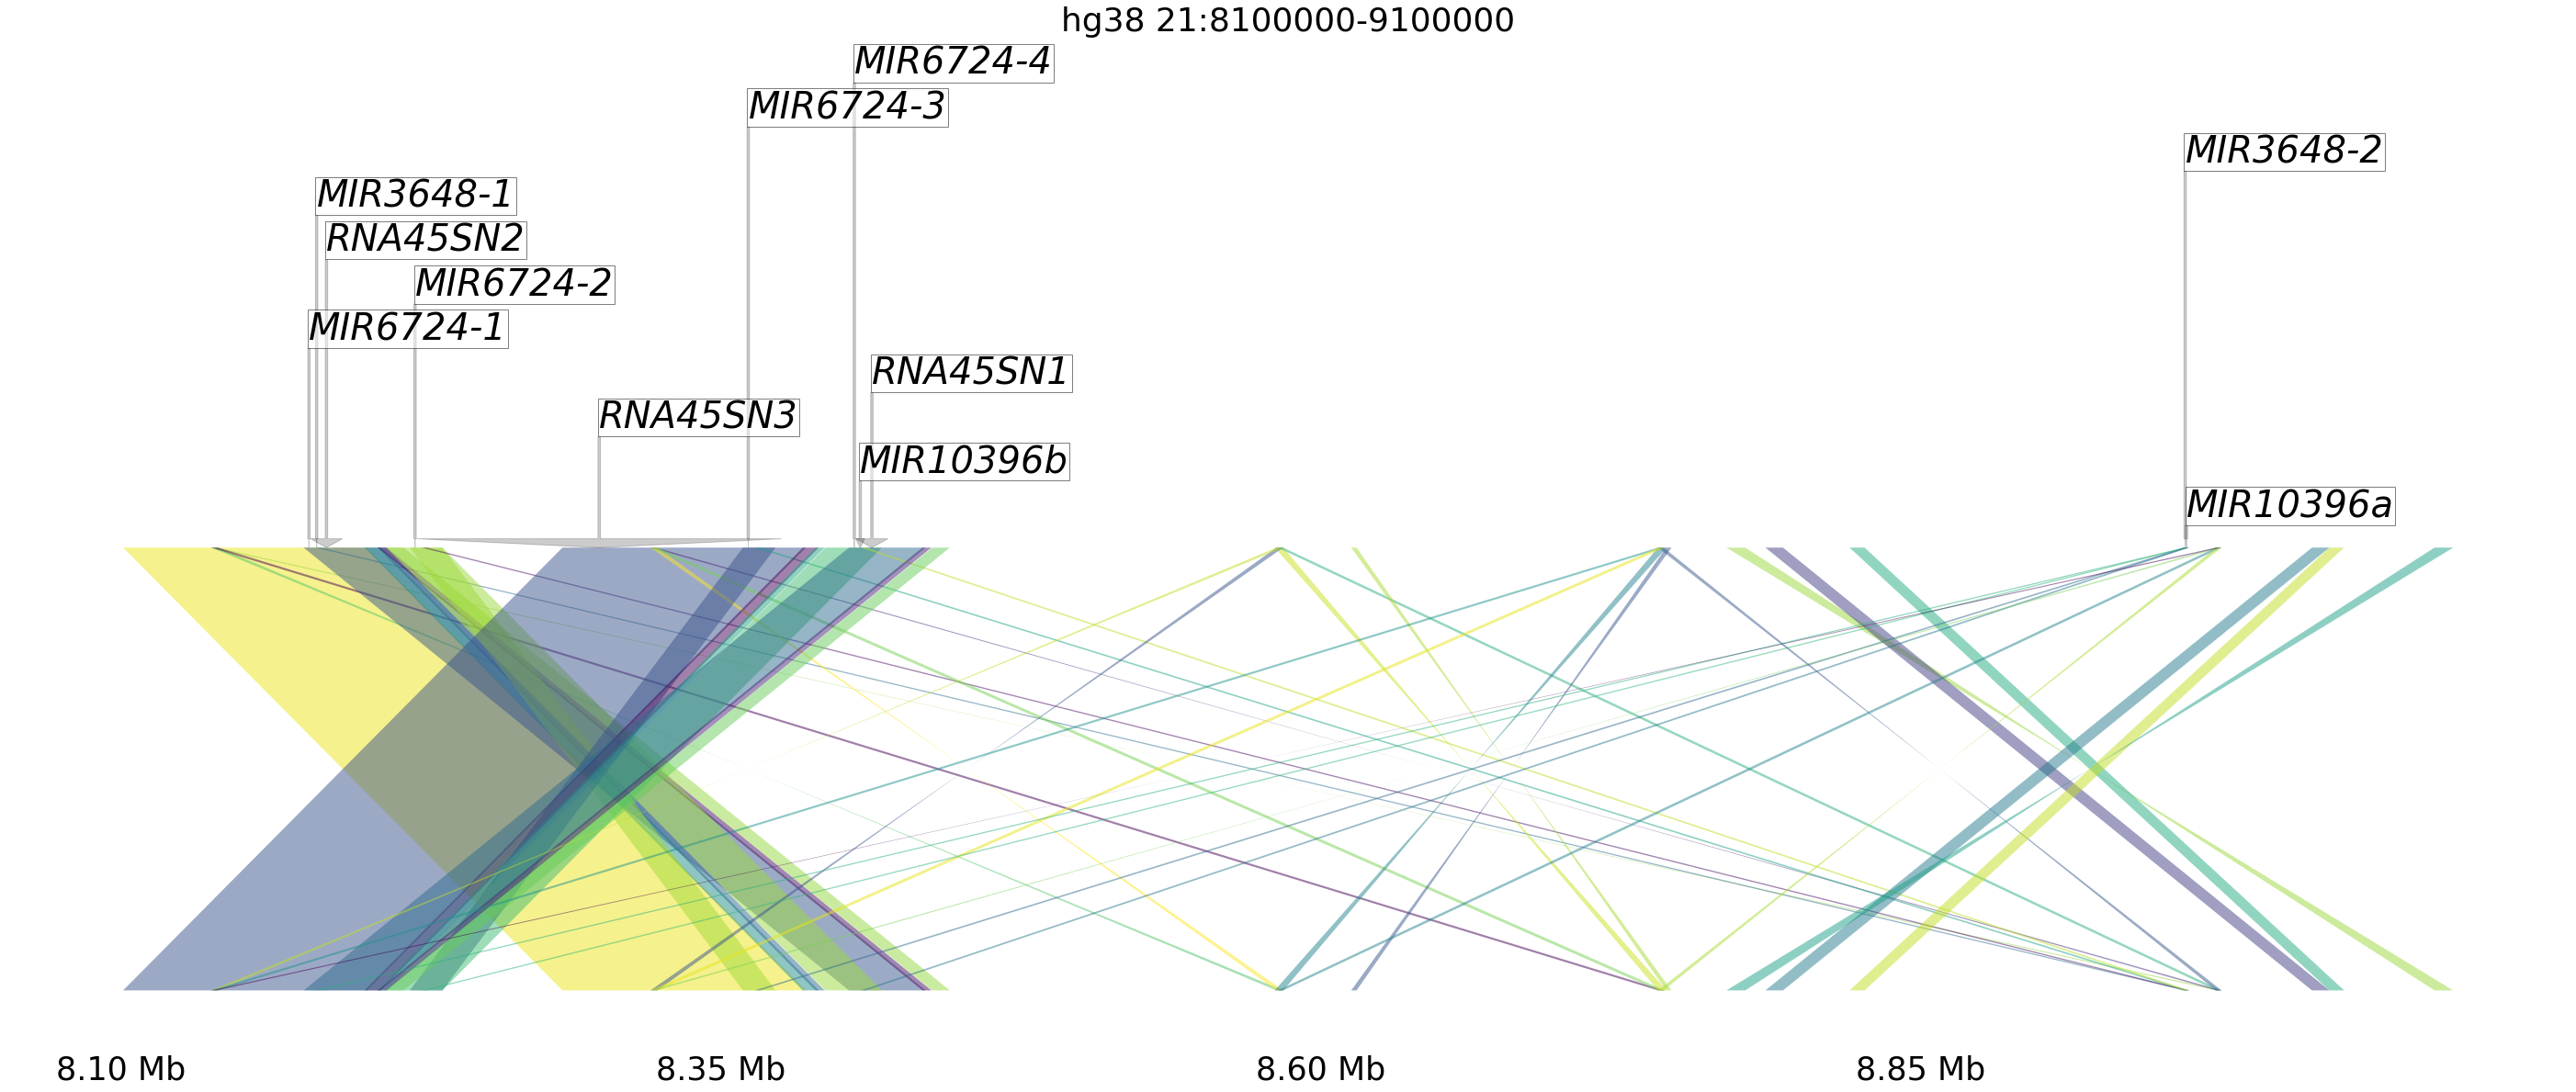

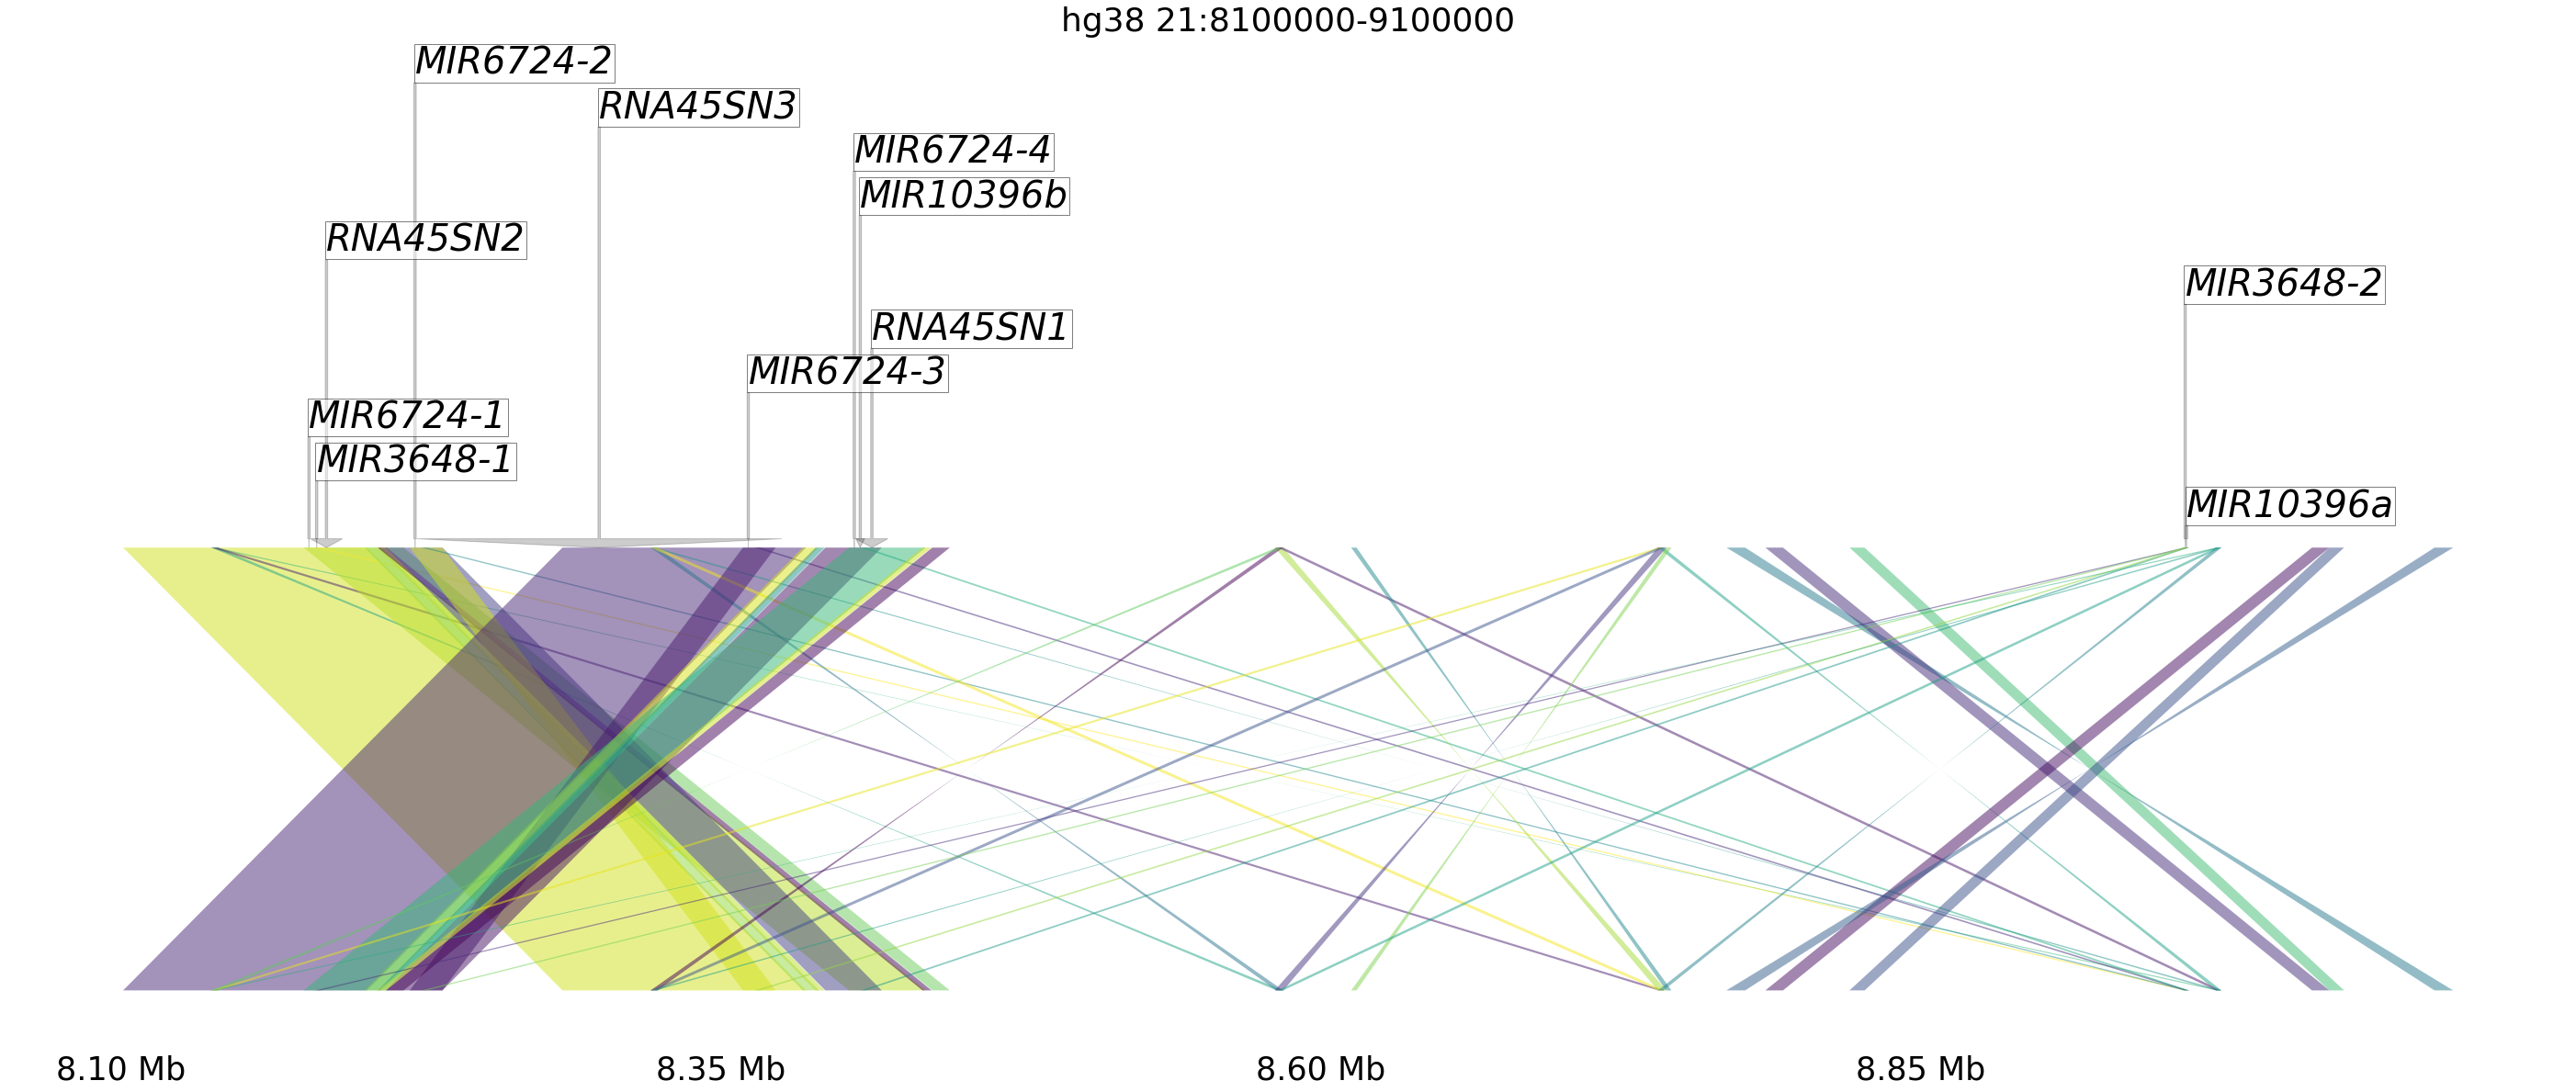

In [237]:
rg,loc,ref_file = write_region(chr21,start,end,chromo)

print("loc={}".format(loc))


nuc_up(loc,ref_file,recompute=True)    


top_intervals,bottom_intervals = get_intervals(loc,rg)
print("number of polygons: {}".format(len(top_intervals)))

import pickle

fti = open("top_intervals.pkl","wb")
fbi = open("bottom_intervals.pkl","wb")

pickle.dump(top_intervals,fti)
pickle.dump(bottom_intervals,fbi)

fti.close()
fbi.close()
#349,16,44
for i in range(2):
    newdrawpic(start,end,chromo,top_intervals,bottom_intervals,locFeatures)



In [229]:
## Debug

nuc_dat_file="pnrma_files/loc21:8000000-9100000.coords"
columns=["s1","e1","s2","e2","len1","len2","pID","tag1","tag2"]
df=pd.read_csv(nuc_dat_file,delimiter="\t",skiprows=1,header=None)
df.columns=columns
df

,s1,e1,s2,e2,len1,len2,pID,tag1,tag2
0,1,1100000,1,1100000,1100000,1100000,100.00,21,21
1,1,506,44252,44765,506,514,84.33,21,21
2,1,506,29444,29957,506,514,84.33,21,21
3,1,506,4930,5443,506,514,82.98,21,21
4,1,506,26205,26718,506,514,83.95,21,21
...,...,...,...,...,...,...,...,...,...
919,1096391,1099879,797928,794476,3489,3453,87.78,21,21
920,1098147,1100000,1098147,1099904,1854,1758,93.74,21,21
921,1096391,1100000,797928,794451,3610,3478,85.95,21,21
922,1098776,1099995,1096392,1097607,1220,1216,83.32,21,21


In [12]:
## open image using Eye of Gnome image viewer (Linux only)
!eog panorama/{chromo}_{start}_{end}.svg

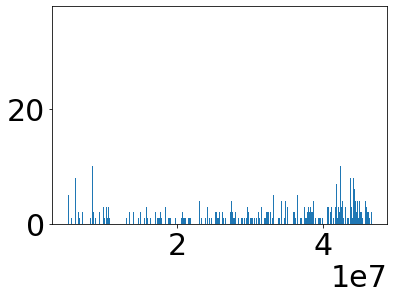

In [137]:
### Adding hotspot features


import gffutils
filename="/home/hunter/Genome/Homo_sapiens.GRCh38.98.gff3"
database_filename = "/home/hunter/Documents/jupyter_nb/hg38.db"

#db = gffutils.create_db(filename, dbfn=database_filename, force=True, keep_order=True, merge_strategy='merge', sort_attribute_values=True)

chromo=21

db = gffutils.FeatureDB(database_filename, keep_order=True)

chr21fa="/home/hunter/Genome/hg38_chr21.fa"

from Bio import SeqIO

ref_genome =  SeqIO.parse(chr21fa, "fasta")
chr21=next(ref_genome)



sevenmer = "CCTCCCT"
locs = []
start = 0

while True:
    L = chr21.seq.find(sevenmer,start)
    if L == -1:
        break
    locs.append(L)
    start = L+1
    
    
a = np.array(locs)
    
bins = plt.hist(a, bins=5000)[:2]
    

In [156]:
p = zip(bins[0],bins[1])
start=8100000
end=8500000
p = list(p)
H=[pp for pp in p if start < pp[1] < end]

21:8100000-8500000
ref_file = /home/hunter/Genome/pnrma_21:8100000-8500000.fa
nucup = pnrma_files/loc21:8100000-8500000.coords
df shape =          s1      e1      s2      e2    len1    len2     pID  tag1  tag2
0         1  400000       1  400000  400000  400000  100.00    21    21
1      4061    4356  144653  144363     296     291   86.49    21    21
2      4061    4356  372238  371948     296     291   86.15    21    21
3      4061    4356  327677  327387     296     291   86.49    21    21
4     13181   13580   62540   62941     400     402   80.30    21    21
..      ...     ...     ...     ...     ...     ...     ...   ...   ...
117  367719  367844  146432  146303     126     130   87.02    21    21
118  371948  372238    4356    4061     291     296   86.15    21    21
119  371944  372227   27286   27568     284     283   85.61    21    21
120  372356  400000  160967  188611   27645   27645  100.00    21    21
121  372357  400000  210975  183332   27644   27644  100.00    21    2

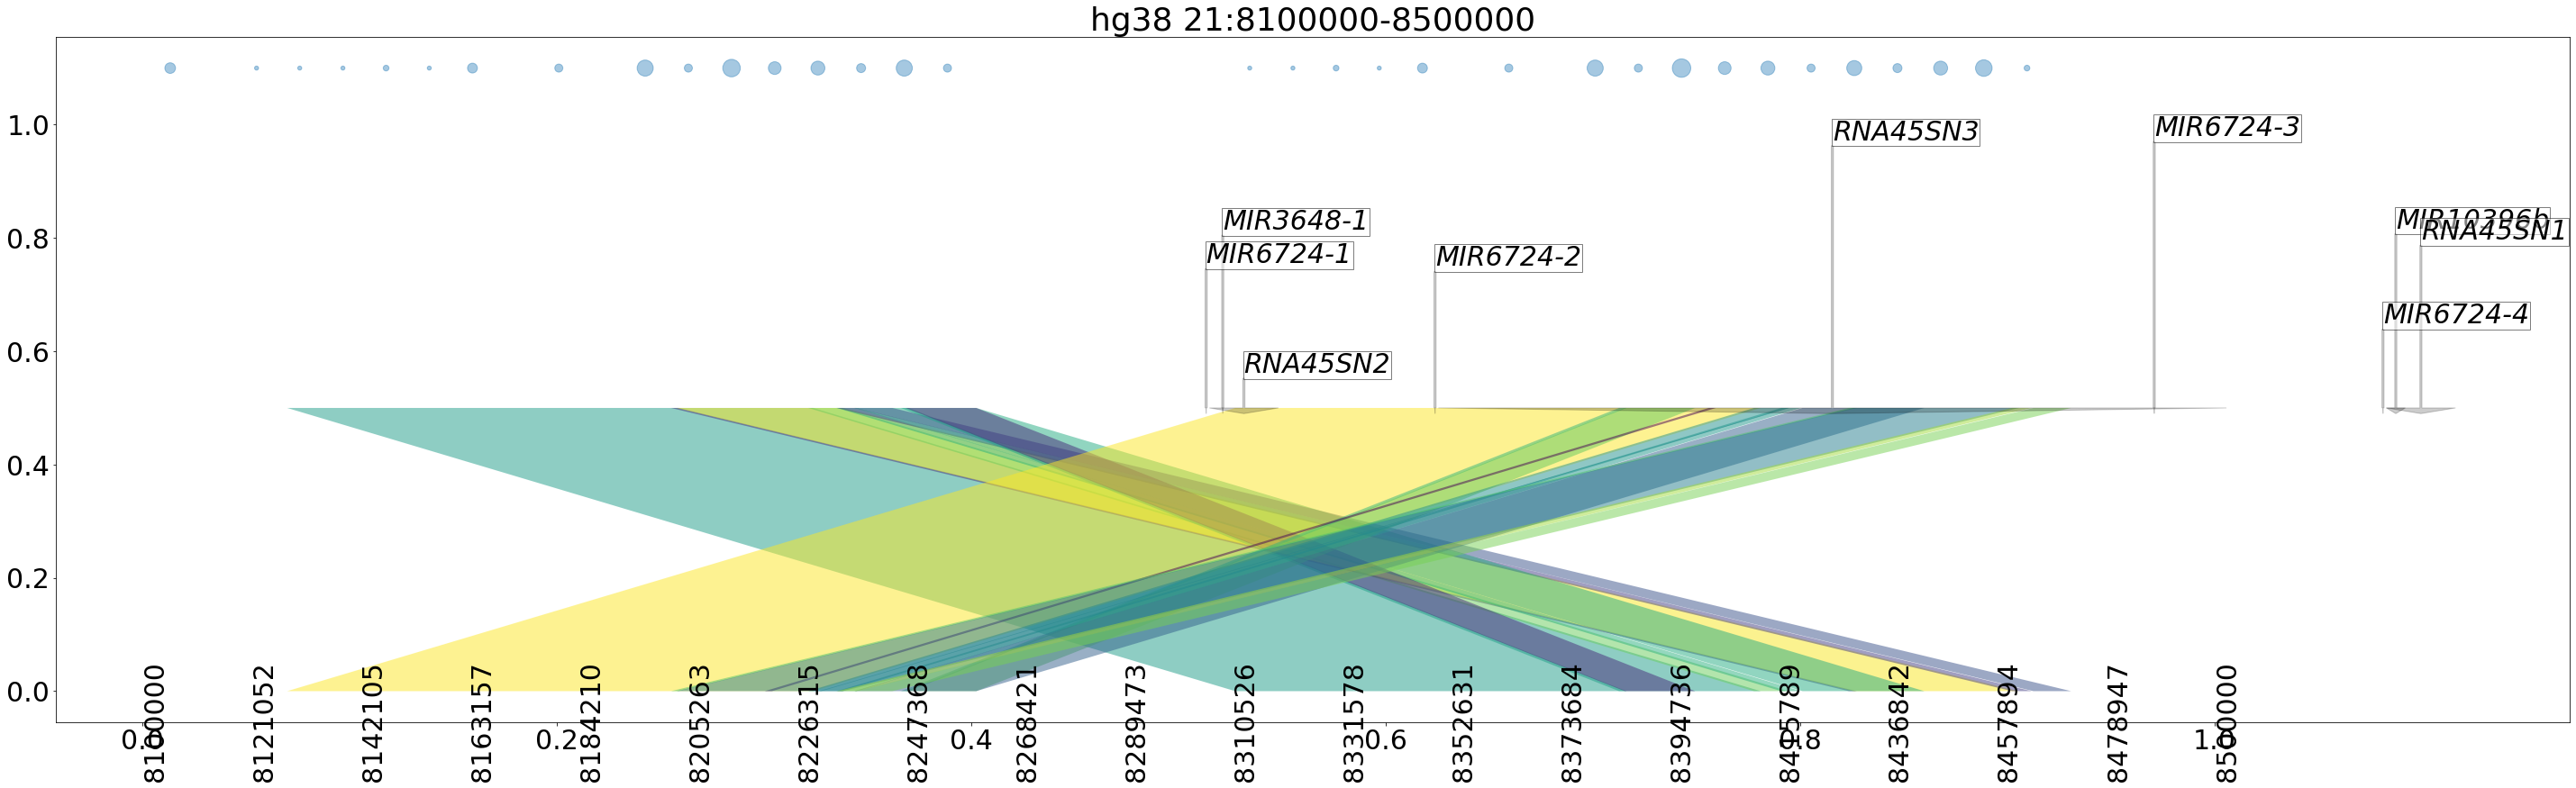

In [157]:


start,end = 8100000,8500000

locFeatures=get_loc_features(chromo,start,end)

rg,loc,ref_file = write_region(chr21,start,end,chromo)



nuc_up(loc,ref_file)    


top_intervals,bottom_intervals = get_intervals(loc,rg)
print("number of polygons: {}".format(len(top_intervals)))


locFeatures=[['MIR6724-1', 'miRNA', 21, 205315, 205406],
 ['MIR3648-1', 'miRNA', 21, 208473, 208652],
 #['RNA5-8SN2', 'rRNA', 21, 212572, 212724],
 ['MIR6724-2', 'miRNA', 21, 249505, 249596],
 ['MIR6724-3', 'miRNA', 21, 388362, 388453],
 #['RNA5-8SN3', 'rRNA', 21, 395607, 395759],
 ['MIR6724-4', 'miRNA', 21, 432530, 432621],
 ['MIR10396b', 'miRNA',21,mir10396Bstart,mir10396Bend],
 #['RNA5-8SN1', 'rRNA', 21, 439823, 439975],
 ['RNA45SN1','rRNA',21,433222,446572],
 ['RNA45SN2','rRNA',21,205988,219302],
 ['RNA45SN3','rRNA',21,250197,402343]]


drawhotspot(start,end,chromo,top_intervals,bottom_intervals,locFeatures,H)
#drawpic(start,end,chromo,top_intervals,bottom_intervals,locFeatures)